In [1]:
import sys
sys.path.append('../recognition')

In [2]:
import recognition
from typing import Union, Tuple
import torch
import torchvision.transforms as T
import numpy as np
from torch import nn
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import distance
import utils

In [3]:
recognition.get_model

<function recognition.get_model(model_name: str = 'vgg') -> torch.nn.modules.module.Module>

In [31]:
def get_model(model_name: str = "vgg") -> torch.nn.Module:
    """Return the most up to date model

    Returns:
        nn.Module: Pytorch model set to eval
    """
    types = (str,)
    available_model_names = ("vgg", "inception")
    utils.type_check(model_name, types)

    model_name = model_name.lower()
    if model_name not in available_model_names:
        raise ValueError(f"Expected {model_name} to be one of {available_model_names}")
    if model_name == "vgg":
        model = VGG_16()
        model.load_weights()
        model.eval()
    elif model_name == "inception":
        model = InceptionResnetV1(pretrained="casia-webface").eval()
    return model


In [32]:
model = get_model()

In [5]:
VGG_16 = recognition.VGG_16

In [6]:
class DefaultMTCNN(MTCNN):
    def __init__(self):
        super().__init__(image_size=224,
    margin=0,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    device="cpu")

In [7]:
from typing import Union, get_type_hints, Optional
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import PIL.PngImagePlugin
import PIL.JpegImagePlugin

In [9]:
def check_image_channels(img: Union[np.ndarray, Image.Image], num_channels=3) -> None:
    """Checks image channels to be equal to num_channels"""
    types = (np.ndarray, Image.Image, PIL.PngImagePlugin.PngImageFile, PIL.JpegImagePlugin.JpegImageFile) # Last option is a workaround.
    utils.type_check(img, types)
        
    if isinstance(img, np.ndarray):
        assert img.ndim == num_channels, f"Expected image to have ndim <= {num_channels}, but got {img.ndim}"
    if isinstance(img, Image.Image):
        if type(img) != Image.Image:
            img = img.convert("RGB")
        img_array = np.array(img)
        check_image_channels(img_array)
    

In [10]:
check_image_channels(5)

TypeError: Wrong type (<class 'int'>) passed. Expected one of (<class 'numpy.ndarray'>, <class 'PIL.Image.Image'>, <class 'PIL.PngImagePlugin.PngImageFile'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>)

In [36]:
def load_image(image: Union[str, np.ndarray, Image.Image, PIL.PngImagePlugin.PngImageFile, PIL.JpegImagePlugin.JpegImageFile]) -> np.ndarray:
    types = (str, np.ndarray, Image.Image, PIL.PngImagePlugin.PngImageFile, PIL.JpegImagePlugin.JpegImageFile)
    utils.type_check(image, types)
    img = image
    if type(image) == str:
        img = Image.open(image)
    if not isinstance(img, np.ndarray):
        img = img.convert('RGB')
    img = np.array(img)
    return img
        

In [15]:
img = np.array(Image.open("../images/1.PNG").convert("RGB"))

In [38]:
load_image(5)

TypeError: Wrong type (<class 'int'>) passed. Expected one of (<class 'str'>, <class 'numpy.ndarray'>, <class 'PIL.Image.Image'>, <class 'PIL.PngImagePlugin.PngImageFile'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>)

In [18]:
mtcnn = DefaultMTCNN()

In [19]:
boxes, _  = mtcnn.detect(img)

In [20]:
boxes

array([[157.14366, 303.18332, 561.55054, 868.8334 ]], dtype=float32)

In [21]:
def extract_face(img: Union[np.ndarray, Image.Image], mtcnn) -> Image.Image:
    """Extracts the bounding box containing only the first face and return a crop of only that face.

    Returns:
        PIL Image: shape 160,160,3
    """
    types = (np.ndarray, Image.Image)
    utils.type_check(img, types)
    
    check_image_channels(img)
    boxes, _ = mtcnn.detect(img)

    if len(boxes) >= 1 and len(boxes) != 4:
        box = boxes[0]
        
    cropped = img.crop(box) if type(img) == Image.Image else Image.fromarray(img).crop(box)

    return cropped

In [24]:
def display_image(img: Union[Image.Image, np.ndarray], ax:Optional=None ) -> None:
    """Displays PIL image, optionally can be used to stack images together

    Args:
        img (PIL Image): Image to be displayed.
        ax ([Axes], optional): Axes from the previous plt call to stack together. Defaults to None.
    """
    types = (Image.Image, np.ndarray)
    
    utils.type_check(img, types)
    check_image_channels(img)
    if isinstance(img, Image.Image):
        img = np.array(img)
    if ax:
        ax.imshow(img)
    else:
        plt.imshow(img)


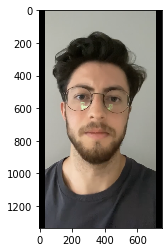

In [25]:
fig, ax = plt.subplots()
display_image(img, ax)
display_image(img, ax)
plt.show()

In [28]:
default_mtcnn = DefaultMTCNN()

In [48]:
def torch_to_np(array: torch.Tensor) -> np.ndarray:
    """Coverts torch tensor to numpy array, handles the case when torch tensor is
     stuck in cuda.

    Args:
        array (torch.Tensor): Pytorch Tensor

    Returns:
        np.ndarray
    """
    types = (torch.Tensor)
    utils.type_check(array, types)
    
    if array.is_cuda:
        array = array.cpu()
    return array.detach().numpy()

In [49]:
def get_embedding(image: Union[np.ndarray, Image.Image] , model, mtcnn=default_mtcnn) -> torch.Tensor:
    """Runs the PIL image though the model after preprocessing

    Args:
        image (Image.Image): PIL image
        model (nn.Module): Pytorch model
        mtcnn (optional): Defaults to None.

    Returns:
        [type]: [description]
    """
    types = (np.ndarray, Image.Image)
    utils.type_check(image, types)

    resize = T.Resize([mtcnn.image_size] * 2)
    to_tensor = T.ToTensor()

    with torch.no_grad():

        Img1 = to_tensor(resize(extract_face(image, mtcnn)))
        embedding = model(Img1.unsqueeze(0))

    return embedding

In [50]:
get_embedding(img, model)

tensor([[ 0.0269, -0.0030, -0.0023,  ..., -0.0146,  0.0086,  0.0088]])

In [44]:
def verify(
    img1: Union[Image.Image, str],
    img2: Union[Image.Image, str],
    model: nn.Module,
    mtcnn: MTCNN = default_mtcnn,
    dist_fn: str = "euclidean",
    plot: bool = True,
    decision: bool = True,
) -> Union[Tuple[bool, float], float]:
    """Compares two images by the distance between their embeddings

    Args:
        img1 (Union[Image.Image, str]): Either PIL or path
        img2 (Union[Image.Image, str]): Either PIL or path
        model (nn.Module): A pytorch model.
        mtcnn (MTCNN, optional): User defined MTCNN. Defaults to None.
        dist_fn (str, optional): Current opetions are euclidean or cosine. Defaults to "euclidean".
        plot (bool, optional): Matplotlib plot. Defaults to True.
        decision (bool, optional): [description]. Defaults to True.

    Returns:
        Union[Tuple[bool, float]]: Distance between the embeddings
    """
    img_types = (str, Image.Image, np.ndarray)
    utils.type_check(img1, img_types)
    utils.type_check(img2, img_types)

    img1 = load_image(img1)
    img2 = load_image(img2)

    img1_embedding = get_embedding(img1, model, mtcnn)
    img2_embedding = get_embedding(img2, model, mtcnn)

    img1_embedding_np = torch_to_np(img1_embedding)
    img2_embedding_np = torch_to_np(img2_embedding)

    if plot:
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        display_image(img1, ax1)
        ax2 = fig.add_subplot(122)
        display_image(img2, ax2)
        plt.show()

    if dist_fn == "euclidean":
        dist = distance.euclidean(img1_embedding_np, img2_embedding_np)

    elif dist_fn == "cosine":
        dist = distance.cosine(img1_embedding_np, img2_embedding_np)

    elif dist_fn == "both":
        dist1 = distance.euclidean(img1_embedding_np, img2_embedding_np)
        dist2 = distance.cosine(img1_embedding_np, img2_embedding_np)
        dist = np.array([dist1, dist2]).mean()

    if decision:
        return dist < 0.56, dist

    return dist

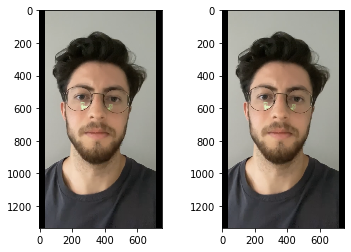

(True, 0.0)

In [47]:
verify(img, img, model)

In [ ]:
Union[IMAGE_TYPES]